# Exercise 7

In [1]:
# Load packages
import pandas as pd
import numpy as np
from numpy import cov
from scipy.stats import pearsonr
import os
import sys
sys.path.append("/Users/mikelgallo/repos/master_repo") # main path to repo
import matplotlib.pyplot as plt

#Importing own functions
import function_folder.inference as hh
from function_folder.inference import *

### Description of variables

1) Corruption - Index defined so higher values mean higher corruption.  
2) gdp - GDP per Capita  
3) Socialnetshare - Measure of social media penetration

### Goals
1) Plot scatterplot with corruption(y-axis) and socialnetshare(x-axis) - What can you conclude?  
2) Split countries by their GDP level in quintiles then plot the same scatterplot for top and bottom quintiles. What can you conclude?

### Load and review dataset

In [2]:
dataset = pd.read_csv('/Users/mikelgallo/repos/master_repo/brush_up_homework/PrepHomework_data.csv')

In [3]:
print(dataset.head())

         obs  socialnetshare      lngdp  corruption
0  Argentina     4320.000000   8.962254   93.970001
1  Australia     7296.000000  10.037756   83.639999
2    Austria     6464.619629  10.138426   85.750000
3    Belgium     6975.000000  10.076495   85.910004
4   Botswana             NaN   8.401951   88.309998


In [4]:
pop_parameters(dataset[['socialnetshare','lngdp','corruption']])

,size,datatype,unique_values,mean,stdv,min,per25,median,per75,max,IQRs,lower_bound,upper_bound
socialnetshare,47,float64,36,5491.91,2096.26,712.50,3803.36,5920.40,7292.55,8527.68,3489.19,0.00,12526.34
lngdp,47,float64,47,8.71,1.38,6.08,7.70,8.75,10.06,10.59,2.36,4.17,13.59
corruption,47,float64,45,89.57,4.14,82.48,85.90,90.32,93.31,95.40,7.40,74.79,104.41


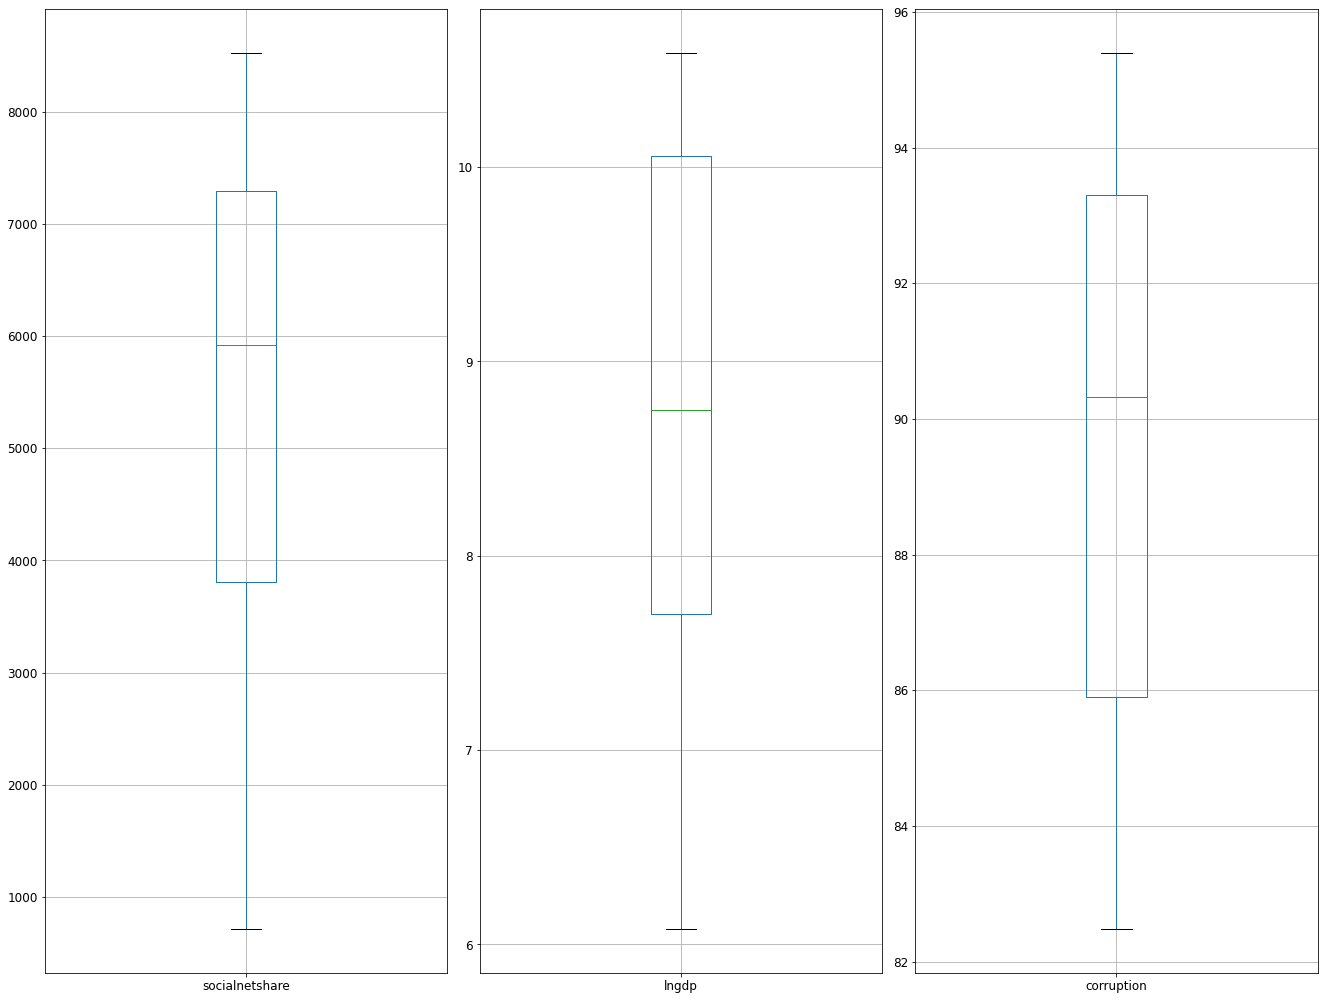

In [5]:
plot_box_mult(dataset[['socialnetshare','lngdp','corruption']],1,3)

In [6]:
missing_summary(dataset)

,n,missing_values,missing_perc
socialnetshare,47,12,0.2553
lngdp,47,1,0.0213


#### Problem:
- We are missing values of socialnetshare for 12 countries  
- One country missing a lngdp value  
  
If we want to plot a scatterplot using socialnetshare and corruption, we'll need to fill those missing values with an estimation

### Which countries are missing values?

In [7]:
dataset[dataset['socialnetshare'].isna()]

,obs,socialnetshare,lngdp,corruption
4,Botswana,NaN,8.401951,88.309998
10,Cuba,NaN,NaN,91.559998
11,CzechRepublic,NaN,8.777563,90.949997
14,Greece,NaN,9.441840,92.669998
15,Hungary,NaN,8.656500,90.040001
21,Kenya,NaN,6.079487,95.400002
24,Morocco,NaN,7.218006,93.300003
28,Pakistan,NaN,6.372428,95.199997
34,Senegal,NaN,6.133033,93.550003
35,Serbia,NaN,6.961033,93.309998


In [8]:
missing_countries = dataset['obs'][dataset['socialnetshare'].isna()]
x = dataset['obs']
y = dataset['lngdp']

### How should we proceed to fill the missing values?

We'll use the lngpd variable to "classify" countries with missing values.
 - By identifying the thresholds of gpd we'll be able to identify "similar" benchmark countries that will help us approximate the missing socialnetshare values more accurately.  
 
### What about Cuba?
 - Given that we don't count with either lngdp nor socialnetshare, we'll approximate it's missing values using benchmark countrie's crime rates

### Step 1 - Determine gdp thresholds

In [9]:
dataset_test = dataset.sort_values('lngdp',ascending = True)

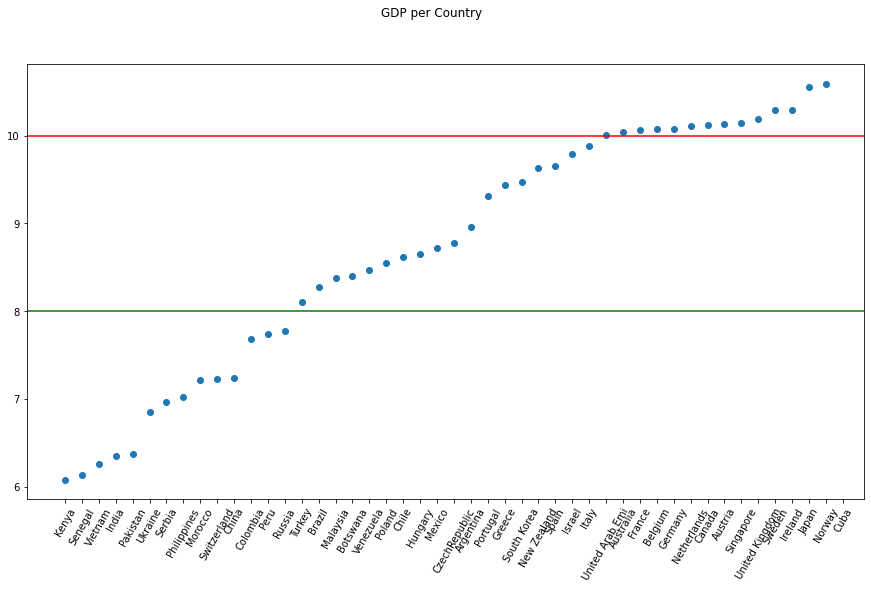

In [10]:
fig, axs = plt.subplots(figsize=(15, 8))
axs.scatter(dataset_test['obs'], dataset_test['lngdp'])
#axs[2].plot(names, values)
plt.axhline(y = 10, color = 'r', linestyle = '-')
plt.axhline(y = 8, color = 'g', linestyle = '-')
axs.xaxis.set_ticks(dataset_test['obs'])
axs.set_xticklabels(dataset_test['obs'], rotation = 60)
fig.suptitle('GDP per Country')
plt.show()

### Methodology
- Used percentiles 25 (7.70) , 50 (8.75) and 75 (10.06) as reference  
- Used GDP per country Scatterplot to visually define thresholds


### GDP thresholds
 - gdp >= 10  
 - gdp >= 8 and gdp < 10  
 - gdp < 8


#### Countries with gdp >= 10

In [11]:
df_plus_10 = dataset[dataset['lngdp']>= 10]

In [12]:
df_plus_10

,obs,socialnetshare,lngdp,corruption
1,Australia,7296.000000,10.037756,83.639999
2,Austria,6464.619629,10.138426,85.750000
3,Belgium,6975.000000,10.076495,85.910004
6,Canada,7548.200195,10.120504,83.820000
12,France,7289.100098,10.061701,86.519997
13,Germany,7380.000000,10.079989,84.930000
17,Ireland,6635.750000,10.298805,86.250000
20,Japan,4536.180176,10.561085,85.889999
25,Netherlands,8527.679688,10.113116,83.660004
27,Norway,8311.709961,10.588329,83.680000


In [13]:
def summary_stats(dataset):
    statistics = {}

    for i in dataset.columns:
        mean = np.mean(dataset[i])
        stdv = np.std(dataset[i])
        median = dataset[i].quantile(0.50)
        diff = abs(mean - median)
        perc_change = abs((mean/median)-1)

        statistics[i] = (mean,median,stdv,diff,perc_change)
    results = pd.DataFrame.from_dict(statistics,orient='index',columns=['mean','median','stdv','diff','perc_change'])
    return round(results,2)

In [14]:
summary_stats(df_plus_10[['socialnetshare','lngdp','corruption']])

,mean,median,stdv,diff,perc_change
socialnetshare,7256.79,7296.00,1039.81,39.21,0.01
lngdp,10.19,10.13,0.18,0.07,0.01
corruption,84.91,85.08,1.44,0.17,0.00


#### countries with missing socialnetshare values (gdp >= 10)
We'll fill their missing values using the median 7296 as it is more robust than the mean value.

#### Countries with gdp >= 8 and gdp <10

In [15]:
df_btw_8_10 = dataset[(dataset['lngdp']>= 8) & (dataset['lngdp']< 10) ]

In [16]:
df_btw_8_10

,obs,socialnetshare,lngdp,corruption
0,Argentina,4320.000000,8.962254,93.970001
4,Botswana,NaN,8.401951,88.309998
5,Brazil,3943.050049,8.272016,92.400002
7,Chile,4230.000000,8.618376,86.360001
11,CzechRepublic,NaN,8.777563,90.949997
14,Greece,NaN,9.441840,92.669998
15,Hungary,NaN,8.656500,90.040001
18,Israel,6345.000000,9.787876,88.430000
19,Italy,4992.240234,9.877995,91.589996
22,Malaysia,5292.199707,8.380258,90.730003


In [17]:
summary_stats(df_btw_8_10[['socialnetshare','lngdp','corruption']])

,mean,median,stdv,diff,perc_change
socialnetshare,5154.72,5054.52,1406.08,100.2,0.02
lngdp,8.95,8.75,0.56,0.2,0.02
corruption,90.22,90.53,2.97,0.3,0.00


#### countries with missing socialnetshare values (gdp >= 8 and gdp <10)
We'll fill their missing values using the median 5054.52 as it is more robust than the mean value.

### Cuba's corruption rate resembles the most to category (gdp >= 8 and gdp <10)  
#### Considering that the average corruption rates are the most similar to cuba's, we'll fill both socialnetshare and lngdp missing values with category (gdp >= 8 and gdp <10) estimates.

#### Countries with gdp < 8

In [18]:
df_less_8 = dataset[dataset['lngdp']< 8]

In [19]:
df_less_8

,obs,socialnetshare,lngdp,corruption
8,China,1817.899902,7.240613,92.989998
9,Colombia,3504.000000,7.685947,93.040001
16,India,712.500000,6.347274,93.549995
21,Kenya,NaN,6.079487,95.400002
24,Morocco,NaN,7.218006,93.300003
28,Pakistan,NaN,6.372428,95.199997
29,Peru,3337.919922,7.741207,93.029999
30,Philippines,2400.000000,7.019552,94.370003
33,Russia,3784.000000,7.770131,95.050003
34,Senegal,NaN,6.133033,93.550003


In [20]:
summary_stats(df_less_8[['socialnetshare','lngdp','corruption']])

,mean,median,stdv,diff,perc_change
socialnetshare,3214.07,2971.58,1886.59,242.49,0.08
lngdp,6.92,6.99,0.58,0.07,0.01
corruption,93.23,93.55,2.88,0.31,0.00


#### countries with missing socialnetshare values (gdp < 8)
We'll fill their missing values using the median 2971.58 as it is more robust than the mean value.

In [21]:
#Create dataset safety copy
dataset_2 = dataset.copy()

In [22]:
# replace socialnetshare with estimates gdp <8
dataset_2['socialnetshare'] = np.where((dataset_2['socialnetshare'].isna()) & (dataset_2['lngdp'] < 8), 2971.58, dataset_2['socialnetshare'])

In [23]:
# replace socialnetshare with estimates gdp >=8 and gdp <10
dataset_2['socialnetshare'] = np.where((dataset_2['socialnetshare'].isna()) & (dataset_2['lngdp'] >= 8) & (dataset_2['lngdp'] < 10), 5054.52, dataset_2['socialnetshare'])


In [24]:
# replace socialnetshare with estimates gdp >=10
dataset_2['socialnetshare'] = np.where((dataset_2['socialnetshare'].isna()) & (dataset_2['lngdp'] >= 10), 7296, dataset_2['socialnetshare'])


In [25]:
# replace socialnetshare for Cuba (gdp >= 8 and gdp <10)
dataset_2['socialnetshare'] = np.where(dataset_2['obs']== 'Cuba', 5054.52, dataset_2['socialnetshare'])

In [26]:
# replace gdp for Cuba with estimates (gdp >= 8 and gdp <10)
dataset_2['lngdp'] = np.where(dataset_2['obs']== 'Cuba', 8.75, dataset_2['lngdp'])

In [27]:
# View complete dataset
dataset_2

,obs,socialnetshare,lngdp,corruption
0,Argentina,4320.000000,8.962254,93.970001
1,Australia,7296.000000,10.037756,83.639999
2,Austria,6464.619629,10.138426,85.750000
3,Belgium,6975.000000,10.076495,85.910004
4,Botswana,5054.520000,8.401951,88.309998
5,Brazil,3943.050049,8.272016,92.400002
6,Canada,7548.200195,10.120504,83.820000
7,Chile,4230.000000,8.618376,86.360001
8,China,1817.899902,7.240613,92.989998
9,Colombia,3504.000000,7.685947,93.040001


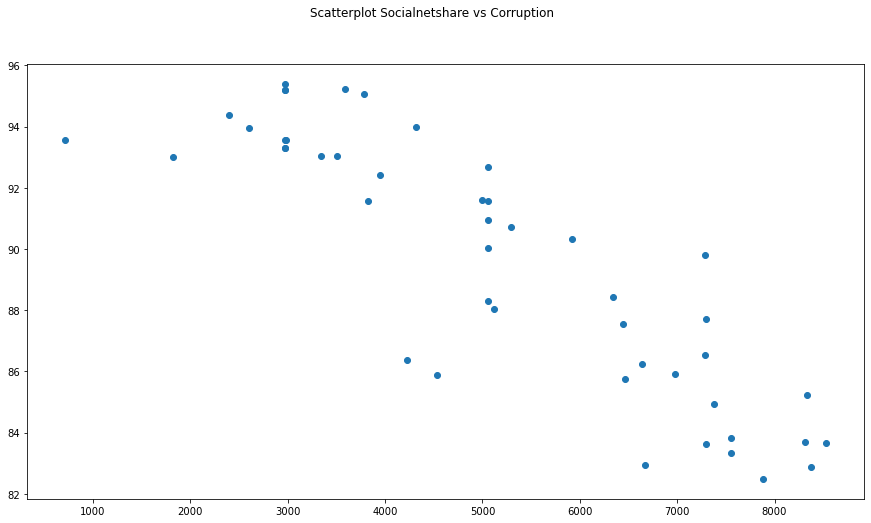

In [28]:
fig, axs = plt.subplots(figsize=(15, 8))
axs.scatter(dataset_2['socialnetshare'], dataset_2['corruption'])
#axs[2].plot(names, values)
#plt.axhline(y = 10, color = 'r', linestyle = '-')
#plt.axhline(y = 8, color = 'g', linestyle = '-')
#axs.xaxis.set_ticks(dataset['obs'])
#axs.set_xticklabels(dataset['obs'], rotation = 60)
fig.suptitle('Scatterplot Socialnetshare vs Corruption')
#b, a = np.polyfit(dataset_2['socialnetshare'], dataset_2['corruption'], deg=1)

# Create sequence of 100 numbers from 0 to 100 
#xseq = np.linspace(2000, 8000, num=100)

# Plot regression line
#axs.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.show()

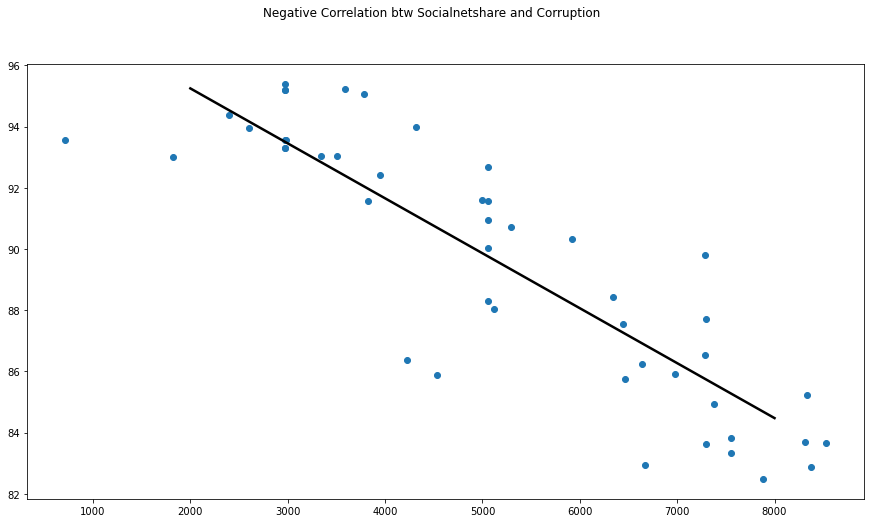

In [29]:
fig, axs = plt.subplots(figsize=(15, 8))
axs.scatter(dataset_2['socialnetshare'], dataset_2['corruption'])
#axs[2].plot(names, values)
#plt.axhline(y = 10, color = 'r', linestyle = '-')
#plt.axhline(y = 8, color = 'g', linestyle = '-')
#axs.xaxis.set_ticks(dataset['obs'])
#axs.set_xticklabels(dataset['obs'], rotation = 60)
fig.suptitle('Negative Correlation btw Socialnetshare and Corruption')
b, a = np.polyfit(dataset_2['socialnetshare'], dataset_2['corruption'], deg=1)

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(2000, 8000, num=100)

# Plot regression line
axs.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.show()

In [30]:
## Covariance Matrix
cov(dataset_2['socialnetshare'], dataset_2['corruption'])

array([[ 4.15238374e+06, -7.45665679e+03],
       [-7.45665679e+03,  1.75458929e+01]])

Given that the covariance for both variables is negative (-7.4567) we can determine that they follow diferent directions. More specifically, as socialnetshare increases the corruption index decreases.

In [31]:
## Calculate Pearson Correlation
corr, _ =pearsonr(dataset_2['socialnetshare'], dataset_2['corruption'])

In [32]:
print(corr)

-0.873590044885793


A correlation of -0.87% indicates that both variables are highly correlated. Strong Negative Relationship.

## Question 2

In [33]:
def quintile_stats(dataset):
    statistics = {}

    for i in dataset.columns:
        perc_20 = dataset[i].quantile(0.20)
        perc_40 = dataset[i].quantile(0.40)
        perc_60 = dataset[i].quantile(0.60)
        perc_80 = dataset[i].quantile(0.80)
        perc_100 = dataset[i].quantile(1.0)
    
        statistics[i] = (perc_20,perc_40,perc_60,perc_80,perc_100)
    results = pd.DataFrame.from_dict(statistics,orient='index',columns=['perc_20','perc_40','perc_60','perc_80','perc_100'])
    return round(results,2)

In [34]:
def quintile_dictionary(dataset):
    statistics = {}

    for i in dataset.columns:
        perc_20 = dataset[i].quantile(0.20)
        perc_40 = dataset[i].quantile(0.40)
        perc_60 = dataset[i].quantile(0.60)
        perc_80 = dataset[i].quantile(0.80)
        perc_100 = dataset[i].quantile(1.0)
    
        statistics[i] = (perc_20,perc_40,perc_60,perc_80,perc_100)
    results = pd.DataFrame.from_dict(statistics,orient='index',columns=['perc_20','perc_40','perc_60','perc_80','perc_100'])
    results =  round(results,2)
    results = results.to_dict('index')
    return results

In [35]:
data_q = dataset_2.sort_values('lngdp',ascending = True)

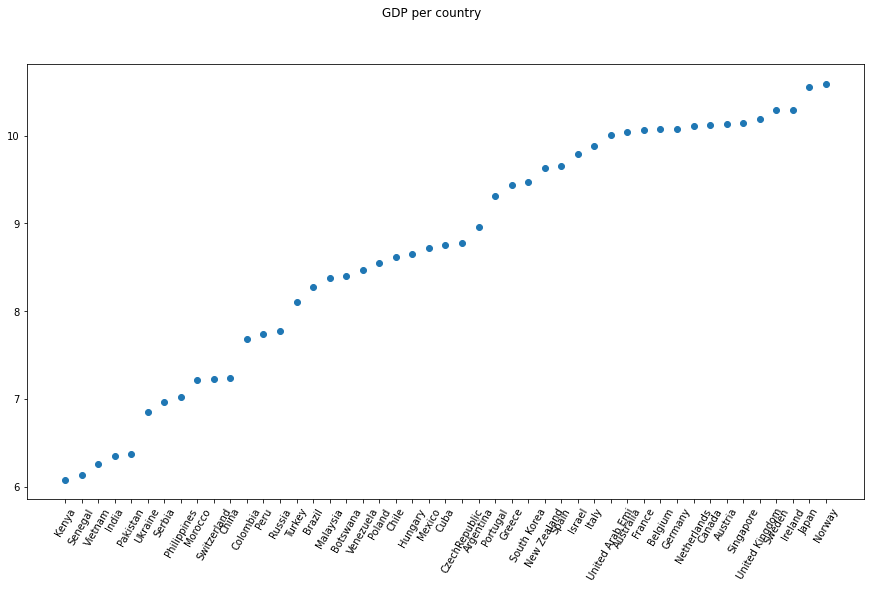

In [36]:
fig, axs = plt.subplots(figsize=(15, 8))
axs.scatter(data_q['obs'], data_q['lngdp'])
#axs[2].plot(names, values)
#plt.axhline(y = 10, color = 'r', linestyle = '-')
#plt.axhline(y = 8, color = 'g', linestyle = '-')
axs.xaxis.set_ticks(data_q['obs'])
axs.set_xticklabels(data_q['obs'], rotation = 60)
fig.suptitle('GDP per country')
#b, a = np.polyfit(dataset_2['socialnetshare'], dataset_2['corruption'], deg=1)

# Create sequence of 100 numbers from 0 to 100 
#xseq = np.linspace(2000, 8000, num=100)

# Plot regression line
#axs.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.show()

In [37]:
quintile_stats(data_q[['socialnetshare','lngdp','corruption']])

,perc_20,perc_40,perc_60,perc_80,perc_100
socialnetshare,2973.42,4406.47,5669.12,7294.62,8527.68
lngdp,7.23,8.50,9.46,10.08,10.59
corruption,85.33,88.15,91.58,93.55,95.40


In [38]:
quint_dict= quintile_dictionary(data_q[['socialnetshare','lngdp','corruption']])

In [39]:
top_and_bottom_q = data_q[(data_q['lngdp'] <= quint_dict['lngdp']['perc_20']) | (data_q['lngdp'] >= quint_dict['lngdp']['perc_80'])]


In [40]:
print(top_and_bottom_q.head())

         obs  socialnetshare     lngdp  corruption
21     Kenya         2971.58  6.079487   95.400002
34   Senegal         2971.58  6.133033   93.550003
46   Vietnam         2605.25  6.261031   93.959999
16     India          712.50  6.347274   93.549995
28  Pakistan         2971.58  6.372428   95.199997


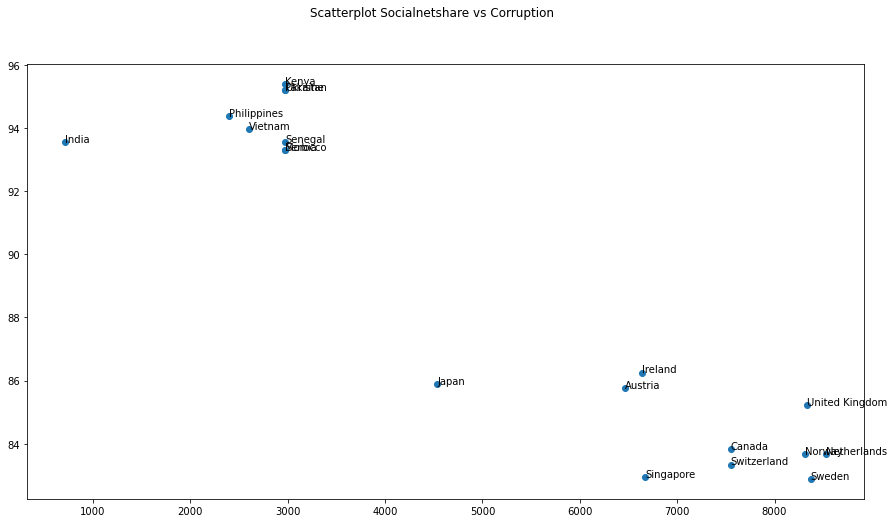

In [41]:
fig, axs = plt.subplots(figsize=(15, 8))
axs.scatter(top_and_bottom_q['socialnetshare'], top_and_bottom_q['corruption'])
for idx, row in top_and_bottom_q.iterrows():
    axs.annotate(row['obs'], (row['socialnetshare'], row['corruption']))
#axs[2].plot(names, values)
#plt.axhline(y = 10, color = 'r', linestyle = '-')
#plt.axhline(y = 8, color = 'g', linestyle = '-')
#axs.xaxis.set_ticks(dataset['obs'])
#axs.set_xticklabels(dataset['obs'], rotation = 60)
fig.suptitle('Scatterplot Socialnetshare vs Corruption')
#b, a = np.polyfit(dataset_2['socialnetshare'], dataset_2['corruption'], deg=1)

# Create sequence of 100 numbers from 0 to 100 
#xseq = np.linspace(2000, 8000, num=100)

# Plot regression line
#axs.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.show()

#### Conclusion

When compared Top and Bottom quintiles (based on gdp), we can observe that low gpd countries tend to have a much lower media penetration (possibly due to limited access to internet / ability to afford devices to get online), which results in a much higher corruption index.  

On the other hand, high gdp countries not only have the highest media penetration but the lowest corruption indexes. Meaning that media penetration helps increase transparency from the public sector by exposing any unlawful activities.